# Определение злонамеренного трафика
Онлайн-сервису с высоким уровнем входящего трафика необходимо автоматизировать выявление аномального и злонамеренного трафика, разработаем модель, которая будет классифицировать трафик на нормальный и злонамеренный.

## Исследовательский анализ проекта

In [82]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [84]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [2]:
import catboost
import dtale
import numpy as np
import optuna
import pandas as pd
import seaborn as sns

from catboost import CatBoostClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from optuna.samplers import TPESampler
from sklearn.metrics import classification_report,  recall_score
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:228: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject



Откроем датасет:

In [85]:
data = pd.read_csv('datasets/network_traffic_data.csv')

data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

Изучим данные с помощью профайлера:

In [ ]:
dtale.show(data)

Уберём из датасета дупликаты:

In [87]:
data = data.drop_duplicates()

В датасете есть признаки, в которых все значения нулевые, исключим их:

In [88]:
zeros= ['Bwd Avg Bulk Rate', ' Bwd Avg Packets/Bulk', ' Bwd Avg Bytes/Bulk', ' Fwd Avg Bulk Rate', ' Fwd Avg Packets/Bulk', 'Fwd Avg Bytes/Bulk', ' Bwd URG Flags', ' Bwd PSH Flags']

In [89]:
for zero in zeros:
    data = data.drop(zero, axis=1)

In [90]:
anomalies = [' Fwd Header Length.1', ' Bwd Header Length', ' Fwd Header Length', ' Flow Duration']

В некоторых колонках присутствую отрицательные значения, хотя по названию признаки связаны с длиной, оценим их колчиество:

In [91]:
data[data[' Fwd Header Length.1'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
54320,123,87016389,14,14,672,672,48,48,48.0,0.0,...,-536870660,3508319.0,4961354.0,7016526,112,40000000.0,41000000.0,69000000,11000000,BENIGN
143024,123,68077496,7,6,336,288,48,48,48.0,0.0,...,-83885313,10077538.0,0.0,10077538,10077538,57922404.0,0.0,57922404,57922404,BENIGN
174622,123,68077957,7,6,336,288,48,48,48.0,0.0,...,-83885313,10078383.0,0.0,10078383,10078383,57921548.0,0.0,57921549,57921549,BENIGN
190149,123,8023666,5,5,240,240,48,48,48.0,0.0,...,-83885313,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
227775,53,227,2,2,68,132,34,34,34.0,0.0,...,-536870660,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [92]:
data[data[' Fwd Header Length'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
54320,123,87016389,14,14,672,672,48,48,48.0,0.0,...,-536870660,3508319.0,4961354.0,7016526,112,40000000.0,41000000.0,69000000,11000000,BENIGN
143024,123,68077496,7,6,336,288,48,48,48.0,0.0,...,-83885313,10077538.0,0.0,10077538,10077538,57922404.0,0.0,57922404,57922404,BENIGN
174622,123,68077957,7,6,336,288,48,48,48.0,0.0,...,-83885313,10078383.0,0.0,10078383,10078383,57921548.0,0.0,57921549,57921549,BENIGN
190149,123,8023666,5,5,240,240,48,48,48.0,0.0,...,-83885313,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
227775,53,227,2,2,68,132,34,34,34.0,0.0,...,-536870660,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [93]:
data[data[' Bwd Header Length'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
54320,123,87016389,14,14,672,672,48,48,48.0,0.0,...,-536870660,3508319.0,4961354.0,7016526,112,40000000.0,41000000.0,69000000,11000000,BENIGN
143024,123,68077496,7,6,336,288,48,48,48.0,0.0,...,-83885313,10077538.0,0.0,10077538,10077538,57922404.0,0.0,57922404,57922404,BENIGN
174622,123,68077957,7,6,336,288,48,48,48.0,0.0,...,-83885313,10078383.0,0.0,10078383,10078383,57921548.0,0.0,57921549,57921549,BENIGN
190149,123,8023666,5,5,240,240,48,48,48.0,0.0,...,-83885313,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
227775,53,227,2,2,68,132,34,34,34.0,0.0,...,-536870660,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Исключим строки с этими данными из датасета:

In [94]:
for anomaly in anomalies:
    data.loc[data[anomaly] < 0, anomaly] = data[anomaly].median()

In [95]:
wrong_data = ['Flow Bytes/s', ' Flow Packets/s']

В указанных колонках присутствуют пропуски, отрицательные значения и  бесконечности, посмотрим на их количество:  

In [96]:
data[data['Flow Bytes/s']==np.inf]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2023,443,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3199,44511,0,1,1,6,2,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6409,443,0,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7883,80,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9749,26,0,2,0,4,0,2,2,2.0,0.0,...,24,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500585,2846,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500737,2876,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500812,2906,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
506684,21,0,2,0,14,0,14,0,7.0,9.9,...,32,0.0,0.0,0,0,0.0,0.0,0,0,FTP-Patator


In [97]:
data[data['Flow Bytes/s'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
6139,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
10236,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
33846,39070,123398,1,1,6,2,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35352,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35392,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35743,41008,123398,1,1,6,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
45839,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
54158,55092,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
65651,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
119215,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [98]:
data[data[' Flow Packets/s']==np.inf]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2023,443,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3199,44511,0,1,1,6,2,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3492,443,0,1,1,0,0,0,0,0.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6409,443,0,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7883,80,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500585,2846,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500737,2876,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
500812,2906,0,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Bot
506684,21,0,2,0,14,0,14,0,7.0,9.9,...,32,0.0,0.0,0,0,0.0,0.0,0,0,FTP-Patator


In [99]:
data[data[' Flow Packets/s'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
6139,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
10236,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
26940,443,123398,1,1,0,0,0,0,0.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
33846,39070,123398,1,1,6,2,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35352,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35392,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
35743,41008,123398,1,1,6,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
45839,443,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
54158,55092,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
65651,80,123398,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [100]:
data[data[' Flow Duration'] < 0]

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label


Заменим аномальные значения на медианные:

In [101]:
for anomaly in wrong_data:
    data.loc[(data[anomaly] < 0) | (data[anomaly] ==np.inf) | (data[anomaly].isna()), anomaly] = data[anomaly].median()

Посмотрим на распределение признаков в таргете:

In [103]:
data['Label'].value_counts()

Label
BENIGN                        232809
DoS Hulk                       87251
DDoS                           64364
PortScan                       56397
DoS GoldenEye                  10286
FTP-Patator                     5933
DoS slowloris                   5385
DoS Slowhttptest                5228
SSH-Patator                     3219
Bot                             1953
Web Attack � Brute Force        1470
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

Целевые признаки крайне несбалансированы, это нужно будет учесть при построении модели.

## Построение baseline модели

Выдели категориальные признаки для модели Катбуст:

In [104]:
cat_features = [' SYN Flag Count', 'FIN Flag Count', ' RST Flag Count',  ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count', ' Destination Port']

Поправим тип данных для модели:

In [105]:
for feat in data.columns.to_list():
    if feat != 'Label':
        data[feat] = data[feat].astype(int)
        
for cat in cat_features:
    data[cat] = data[cat].astype('category')

Выделим целевой признак:

In [106]:
data['Label'] = data['Label'].astype('category')

Разделим данные на тренировочную и тестовую выборку:

In [107]:
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data['Label'])

Разделим тренировочную выборку на таргет и признаки:

In [108]:
features_train = data_train.drop('Label', axis=1)
target_train = data_train['Label']

Создадим валидационную выборку для бэйслайн модели:

In [109]:
X_train, X_valid, y_train, y_valid = train_test_split(features_train, target_train, stratify=target_train, test_size=0.25)

Обучим модель Катбуст со стнадартными параметрами:

In [110]:
model = CatBoostClassifier(task_type="GPU",
                           iterations=150,
                           random_seed=63,
                           loss_function='MultiClass',
                           verbose=False
)

model.fit(X_train, 
          y_train,
          cat_features = cat_features,
          eval_set=(X_valid, y_valid),
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оценим качество модели на валидацинной выборке:

In [111]:
print(classification_report(y_valid, model.predict(data=X_valid)))

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     46562
                       Bot       0.96      0.94      0.95       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       1.00      1.00      1.00      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       0.99      0.99      0.99      1045
             DoS slowloris       0.99      0.99      0.99      1077
               FTP-Patator       1.00      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       1.00      1.00      1.00     11280
               SSH-Patator       1.00      0.99      1.00       644
  Web Attack � Brute Force       0.71      0.90      0.79       294
Web Attack � Sql Injection       0.50      0.25

## Сэмплирование выборки

Текущая модель хорошо работает на распространённых признаках, но очень плохо определяет редкие таргеты, сбалансируем тренировочную выборку для решения этой проблемы:

<Axes: xlabel='Label', ylabel='count'>

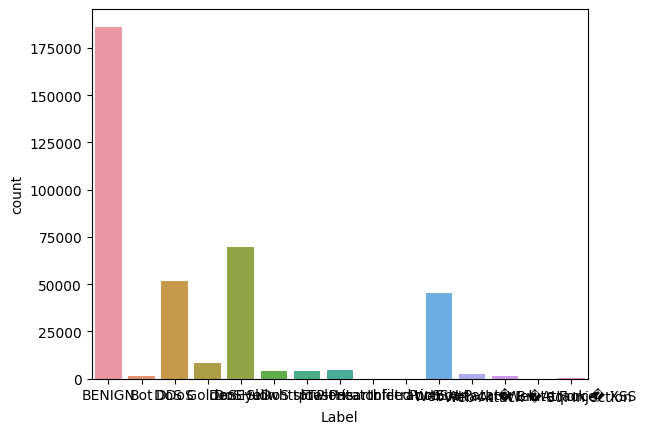

In [114]:
sns.countplot(data_train, x='Label')

In [78]:
sampled_train = data_train

У признаков ['BENIGN', 'DDoS', 'DoS Hulk', 'PortScan'] избыточное количество данных, сократим их значение примерно до 8000:

In [118]:
cats_downsample = ['BENIGN', 'DDoS', 'DoS Hulk', 'PortScan']

for cat in cats_downsample:
    df = sampled_train.loc[sampled_train['Label'] == cat]
    df = df.sample(8000)
    sampled_train = pd.concat([sampled_train.loc[sampled_train['Label'] != cat], df])

<Axes: xlabel='Label', ylabel='count'>

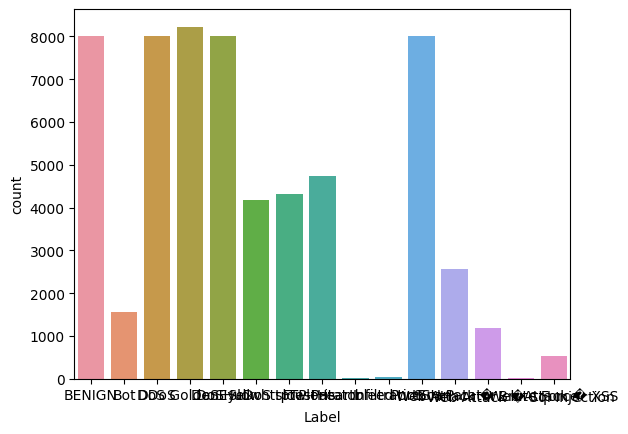

In [119]:
sns.countplot(sampled_train, x='Label')

В текущем датасете не достаточно данных с редкими признаками, проведём ресэмплирование данных:

In [146]:
# Define SMOTE-Tomek Links
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='all'))
X_samp = sampled_train.drop('Label', axis=1)
y_samp = sampled_train['Label']
X_samp, y_samp = resample.fit_resample(X_samp, y_samp)

Ресэмплирование привело к появлению пропущенных данных, удалим их:

In [147]:
X_samp = X_samp.dropna()

In [148]:
y_samp = y_samp[X_samp.index]

Итоговое распределение признаков выглядит следующим образом:

<Axes: xlabel='Label', ylabel='count'>

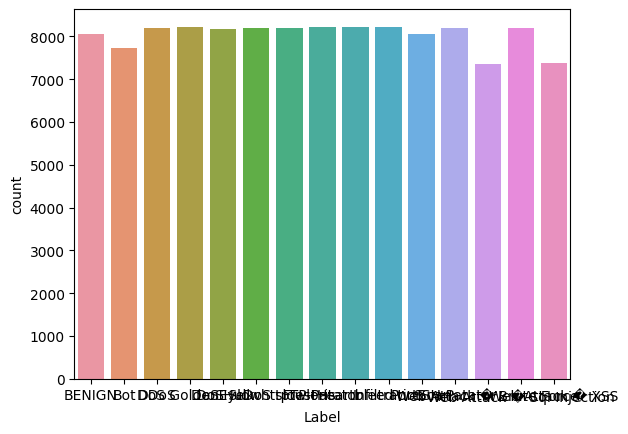

In [149]:
sampled_tr = X_samp.copy()
sampled_tr['Label'] = y_samp
sns.countplot(sampled_tr, x='Label')

## Обучение бэйслан модели на сэмплированной выборке

Разделим сэмплированную выборку на тренировочную и валидационную:

In [150]:
X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp, stratify=y_samp, test_size=0.25)

Обучим модель:

In [151]:
up_model = CatBoostClassifier(task_type="GPU",
                           iterations=150,
                           random_seed=63,
                            loss_function='MultiClass',
                            verbose=False
)

up_model.fit(X_train, 
          y_train,
          cat_features = cat_features,
          eval_set=(X_valid, y_valid),
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [152]:
print(classification_report(y_valid, up_model.predict(data=X_valid)))

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99      2016
                       Bot       1.00      1.00      1.00      1934
                      DDoS       1.00      1.00      1.00      2051
             DoS GoldenEye       1.00      1.00      1.00      2053
                  DoS Hulk       1.00      1.00      1.00      2044
          DoS Slowhttptest       1.00      1.00      1.00      2050
             DoS slowloris       1.00      1.00      1.00      2050
               FTP-Patator       1.00      1.00      1.00      2055
                Heartbleed       1.00      1.00      1.00      2057
              Infiltration       1.00      1.00      1.00      2055
                  PortScan       1.00      1.00      1.00      2017
               SSH-Patator       1.00      1.00      1.00      2049
  Web Attack � Brute Force       0.85      0.78      0.82      1837
Web Attack � Sql Injection       1.00      1.00

Обученная модель показывает значительно лучшие результаты, попробуем улучшить их.

## Подбор гиперпараметров методом .gridsearch()

In [154]:
model = CatBoostClassifier(task_type='GPU', cat_features=cat_features, verbose=False)

grid = {'l2_leaf_reg': [1, 3, 5, 7, 9],
        'learning_rate' : [0.01, 0.03, 0.01, 0.03, 0.1, 0.3],
        'iterations'    : [150, 200, 250]}

grid_search_result = model.grid_search(grid, 
                                       X=X_samp, 
                                       y=y_samp, 
                                       plot=True, 
                                       verbose=False,
                                       stratified=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5722444974
bestIteration = 149
bestTest = 0.1754538539
bestIteration = 149
bestTest = 0.5722444165
bestIteration = 149
bestTest = 0.1754538539
bestIteration = 149
bestTest = 0.07951816893
bestIteration = 149
bestTest = 0.05892536052
bestIteration = 149
bestTest = 0.5817331167
bestIteration = 149
bestTest = 0.1771386954
bestIteration = 149
bestTest = 0.5817331167
bestIteration = 149
bestTest = 0.1771386954
bestIteration = 149
bestTest = 0.08201598109
bestIteration = 149
bestTest = 0.06175266843
bestIteration = 149
bestTest = 0.5859088442
bestIteration = 149
bestTest = 0.1822043705
bestIteration = 149
bestTest = 0.5859088847
bestIteration = 149
bestTest = 0.1822043907
bestIteration = 149
bestTest = 0.08595335578
bestIteration = 149
bestTest = 0.06323199184
bestIteration = 149
bestTest = 0.584498155
bestIteration = 149
bestTest = 0.187939611
bestIteration = 149
bestTest = 0.5844980741
bestIteration = 149
bestTest = 0.1879396312
bestIteration = 149
bestTest = 0.0879574075
best

In [156]:
grid_search_result['params']

{'l2_leaf_reg': 1, 'iterations': 250, 'learning_rate': 0.3}

Обучим модель с найденными гиперпараметрами и оценим её качество на валидационной выборке:

In [157]:
best_model = CatBoostClassifier(task_type="GPU",
                                iterations=250,
                                l2_leaf_reg=1,
                                loss_function='MultiClass',
                                learning_rate=0.3,
                                verbose=False
)

best_model.fit(X_train,
               y_train,
               cat_features = cat_features,
               eval_set=(X_valid, y_valid),
               plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [158]:
print(classification_report(y_valid, best_model.predict(data=X_valid)))

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      1.00      2016
                       Bot       1.00      1.00      1.00      1934
                      DDoS       1.00      1.00      1.00      2051
             DoS GoldenEye       1.00      1.00      1.00      2053
                  DoS Hulk       1.00      1.00      1.00      2044
          DoS Slowhttptest       1.00      1.00      1.00      2050
             DoS slowloris       1.00      0.99      1.00      2050
               FTP-Patator       1.00      1.00      1.00      2055
                Heartbleed       1.00      1.00      1.00      2057
              Infiltration       1.00      1.00      1.00      2055
                  PortScan       1.00      1.00      1.00      2017
               SSH-Patator       1.00      1.00      1.00      2049
  Web Attack � Brute Force       0.87      0.81      0.84      1837
Web Attack � Sql Injection       0.99      1.00

Модель показала схожие результаты, попробуем ещё их улучшить:

## Подбор гиперпараметров с помощью optuna

Оценим важность признаков улучшенной модели:

In [153]:
up_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Init_Win_bytes_backward,25.252623
1,Flow IAT Mean,10.932274
2,min_seg_size_forward,6.893625
3,Bwd Packet Length Std,5.651706
4,Destination Port,5.009670
...,...,...
65,Active Std,0.000000
66,Active Max,0.000000
67,Active Min,0.000000
68,Idle Std,0.000000


Модель оццнивает важность немногих приизнаков на нулевом и околонулевом уровне, уберём их из выборки:

In [159]:
imp = best_model.get_feature_importance(prettified=True)
imp = imp[imp['Importances'] < 1]


In [160]:
X_cropped = X_samp[list(imp['Feature Id'].unique())]
X_cropped.shape

(120638, 46)

Разделим новую выборку на тренировочную и валидационной части:

In [161]:
X_train, X_valid, y_train, y_valid = train_test_split(X_cropped, y_samp, stratify=y_samp, test_size=0.25)

Уточним категориальные приизнаки:

In [162]:
new_cat = [cat for cat in cat_features if cat in list(imp['Feature Id'].unique())]

Зададим сетку гиперпараметров и будем искать лучшую модель с помощью метрики recall, т.к. для данной задачи важно чтобы модель выявляла редкие злонамеренные приизнаки:

In [164]:
def objective(trial):
    model = catboost.CatBoostClassifier(task_type="GPU",
        iterations=trial.suggest_int("iterations", 200, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model.fit(X_train, y_train, cat_features=new_cat)
    y_pred = model.predict(X_valid)
    return recall_score(y_valid, y_pred, average='macro')

In [165]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

Модель с лучшим результатом метрики выглядит следующим образом:

In [166]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.9476778867743331
  Params: 
    iterations: 819
    learning_rate: 0.05373975003237223
    depth: 10
    l2_leaf_reg: 0.0035618307900962863
    bootstrap_type: Bayesian
    random_strength: 5.5300797722684
    bagging_temperature: 0.3286545386734834
    od_type: IncToDec
    od_wait: 15


Обучим модель с полученным набором гиперпараметров на полном наборе признаков:

In [167]:
X_train, X_valid, y_train, y_valid = train_test_split(X_samp, y_samp, stratify=y_samp, test_size=0.25)

In [168]:
tuned_model = CatBoostClassifier(task_type="GPU",
                                loss_function='MultiClass',
                                iterations=819,
                                learning_rate=0.05373975003237223,
                                depth=10,
                                l2_leaf_reg=0.0035618307900962863,
                                bootstrap_type='Bayesian',
                                random_strength=5.5300797722684,
                                bagging_temperature=0.3286545386734834,
                                od_type='IncToDec',
                                od_wait=15,
                                verbose=False
)

tuned_model.fit(X_train,
               y_train,
               cat_features = cat_features,
               eval_set=(X_valid, y_valid),
               plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [169]:
features_test = data_test.drop('Label', axis=1)
target_test = data_test['Label']

Проверим качество модели на тестовой выборке:

In [171]:
print(classification_report(target_test, tuned_model.predict(data=features_test)))

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99     46562
                       Bot       0.63      1.00      0.77       391
                      DDoS       1.00      1.00      1.00     12873
             DoS GoldenEye       0.98      1.00      0.99      2057
                  DoS Hulk       1.00      1.00      1.00     17450
          DoS Slowhttptest       0.99      1.00      0.99      1046
             DoS slowloris       0.98      0.99      0.99      1077
               FTP-Patator       0.99      1.00      1.00      1187
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       0.47      1.00      0.64         7
                  PortScan       1.00      1.00      1.00     11279
               SSH-Patator       0.98      1.00      0.99       644
  Web Attack � Brute Force       0.87      0.79      0.83       294
Web Attack � Sql Injection       0.27      1.00

У конечной модели есть некоторые проблемы с выялением редких признаков, иногда модель ошибочно определяет график как злонамеренный, но в целом результаты приемлемые.  

Сохраним модель:

In [172]:
tuned_model.save_model("cb_model")

## Выводы по проделанной работе:
1. Исследовательский анализ классов выявил закономерный дисбаланс классов, большинство данных приходится на нормальный трафик, а нужно научиться выявлять редко встреающиеся злонамеренные признаки.
2. Для обучения модели было проведено ресэмплирование тренировочной выборки для устранения дисбаланса в целевых признаках.
3. Т.к. в данной задаче важно выявлять редкие признаки, то для оценки качества модели использовалась метрика recall.
4. Модель показывает приемлемые результаты в выявление редких признаков, качество модели можно попробовать улучшить более тщательным подбором гиперпараметров, в первую очередь увеличеним количества итераций.